# all feature to be selected

In [2]:
import numpy as np
import pandas as pd

df_features = pd.read_parquet("data/features.parquet")
df_label = pd.read_parquet("data/label_side.parquet")
assert df_features.shape[0] == df_label.shape[0]
print(df_label.shape)
df_label.head()

(818400, 4)


,close,ret,trgt,bin
index,,,,
2020-06-01 00:00:00+00:00,9439.99,NaN,NaN,0.0
2020-06-01 00:03:00+00:00,9436.93,NaN,NaN,0.0
2020-06-01 00:06:00+00:00,9465.00,NaN,NaN,0.0
2020-06-01 00:09:00+00:00,9475.51,NaN,NaN,0.0
2020-06-01 00:12:00+00:00,9481.59,NaN,NaN,0.0


In [3]:
mask = (df_label["bin"].astype(int) != 0).tolist()

side_features = df_features[mask]
side_label = df_label[mask]["bin"].astype(int)

print(side_features.shape)
print(side_label.shape)

(8557, 1263)
(8557,)


In [4]:
# meta feature selection
from feature_engine.selection import MRMR

sel = MRMR(
    method="FCQ",
    max_features=side_features.shape[1] // 2,
    scoring="f1",
    cv=5,
    regression=False,
    n_jobs=-1,
)
sel.fit(side_features, side_label)

MRMR(cv=5, max_features=631, method='FCQ', n_jobs=-1, scoring='f1')

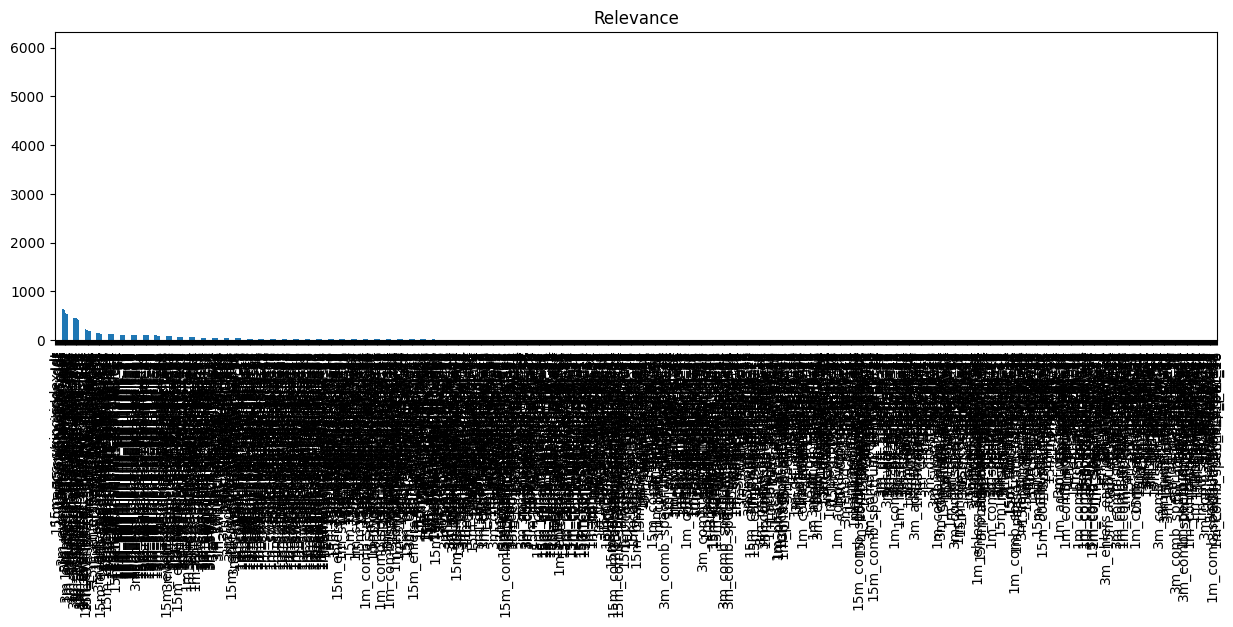

In [5]:
import matplotlib.pyplot as plt

pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False).plot.bar(
    figsize=(15, 4)
)
plt.title("Relevance")
plt.show()

In [6]:
side_res = pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False)
side_res

15m_acc_swing_index_dt      6020.147544
15m_acc_swing_index_ddt     3090.878416
15m_bandpass_ddt            1438.312062
15m_roofing_filter_ddt      1422.423353
15m_bandpass_dt             1299.912108
                               ...     
1m_acp_pwr_28                  0.000068
3m_adaptive_bp_lead_lag1       0.000044
1m_acp_pwr_32                  0.000042
1m_comb_spectrum_pwr_16        0.000020
3m_ac_10                       0.000010
Length: 1263, dtype: float64

In [7]:
import json

with open("data/mrmr_side_features.json", "w") as f:
    json.dump(side_res.to_dict(), f)

In [10]:
feature_info = {
    "all": [],
    "side": {"1m": [], "3m": [], "15m": []},
    "meta": {"1m": [], "3m": [], "15m": []},
}

for k, v in side_res.to_dict().items():
    if v > 10:
        if k.startswith("1m_"):
            feature_info["side"]["1m"].append(k)
            feature_info["all"].append(k.replace("1m_", ""))
        elif k.startswith("3m_"):
            feature_info["side"]["3m"].append(k)
            feature_info["all"].append(k.replace("3m_", ""))
        elif k.startswith("15m_"):
            feature_info["side"]["15m"].append(k)
            feature_info["all"].append(k.replace("15m_", ""))

feature_info["all"] = sorted(list(set(feature_info["all"])))
feature_info["side"]["1m"] = sorted(feature_info["side"]["1m"])
feature_info["side"]["3m"] = sorted(feature_info["side"]["3m"])
feature_info["side"]["15m"] = sorted(feature_info["side"]["15m"])

feature_info["meta"]["1m"] = sorted(feature_info["meta"]["1m"])
feature_info["meta"]["3m"] = sorted(feature_info["meta"]["3m"])
feature_info["meta"]["15m"] = sorted(feature_info["meta"]["15m"])

with open("custom_indicators/feature_info.json", "w") as f:
    json.dump(feature_info, f)